In [1]:
import numpy as np

# always set a seed for reproducibility while learning
rng = np.random.default_rng(42)

## 1) warm-up (low complexity): estimate π with a confidence interval

Problem. Area of a unit circle = π. Throw points uniformly in the square 
[
−
1
,
1
]
2
[−1,1]
2
; proportion inside circle × 4 ≈ π.

In [22]:
def mc_pi(N=1_000_000, rng=np.random.default_rng(42)):
    # sample N points in [-1, 1]^2 - This is basically simulating the random droppage of balls in that square
    pts = rng.uniform(-1.0, 1.0, size=(N, 2))
    # The below line is checking if the point is inside the circle x^2 + y^2 = 1
    inside = (pts[:, 0]**2 + pts[:, 1]**2) <= 1.0
    print (inside) # Observe that it has T, T, F, T, F, F etc.
    # this below line sums up no. of Ts and divides by total number of points 
    phat = inside.mean()
    
    # Ratio of areas- represented in the below cell
    # \frac{N_{\text{in}}}{N} \approx \frac{\text{Area of circle}}{\text{Area of square}} = \frac{\pi \cdot r^2}{4} = \frac{\pi}{4}
    
    pi_hat = 4.0 * phat

    # standard error via Bernoulli variance
    var = phat * (1 - phat) / N
    se = 4.0 * np.sqrt(var)

    # 95% confidence interval using normal approx
    ci = (pi_hat - 1.96 * se, pi_hat + 1.96 * se)
    return pi_hat, se, ci

pi_hat, se, ci = mc_pi(1_000_000, rng)
print(f"π ≈ {pi_hat:.6f}  |  SE ≈ {se:.6f}  |  95% CI: [{ci[0]:.6f}, {ci[1]:.6f}]")


[ True False  True ...  True  True  True]
π ≈ 3.144732  |  SE ≈ 0.001640  |  95% CI: [3.141518, 3.147946]


    Ratio of areas
$$
\frac{N_{\text{in}}}{N} \approx \frac{\text{Area of circle}}{\text{Area of square}} = \frac{\pi \cdot r^2}{4} = \frac{\pi}{4}
$$


In [14]:
# try out what exactly this line does
pts = rng.uniform(-1.0, 1.0, size=(10, 3))
pts
# nice!

array([[ 0.25249926, -0.9346904 , -0.28779169],
       [-0.09252907,  0.78752204, -0.53006035],
       [-0.75815962,  0.08588288,  0.12328329],
       [-0.28337944,  0.81916842, -0.68464258],
       [-0.39125213,  0.59479646, -0.2324236 ],
       [-0.37596439,  0.26076136, -0.47032684],
       [ 0.00395658, -0.97111217,  0.21274188],
       [-0.78773885,  0.63891695,  0.95560284],
       [-0.21295943,  0.17834823,  0.06104103],
       [ 0.51480283,  0.22933792,  0.1738509 ]])

Data visualisation

Bin counts: [ 99714 100227  99914 100039 100313  99986  99765  99899  99963 100180]
Bin edges: [-9.99999750e-01 -7.99999832e-01 -5.99999913e-01 -3.99999995e-01
 -2.00000076e-01 -1.57793210e-07  1.99999761e-01  3.99999679e-01
  5.99999598e-01  7.99999516e-01  9.99999434e-01]


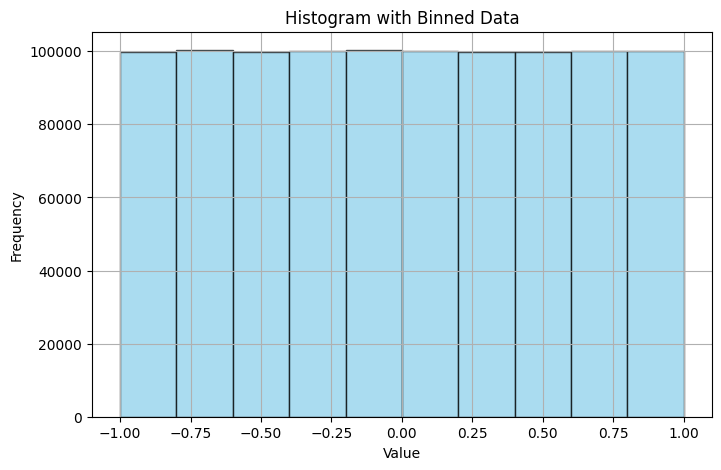

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Choose bin edges or number of bins
num_bins = 10  # You can change this
hist_vals, bin_edges = np.histogram(pts, bins = num_bins)

# Print bin counts and edges
print("Bin counts:", hist_vals)
print("Bin edges:", bin_edges)

# Plot histogram
plt.figure(figsize=(8,5))
plt.hist(pts, bins=num_bins, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Histogram with Binned Data")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


variance reduction: antithetic variates

Use negatively correlated samples to cut variance roughly in half for symmetric problems.

In [5]:
def mc_pi_antithetic(N=1_000_000, rng=np.random.default_rng(42)):
    # generate N/2 samples, then reflect them (antithetic)
    half = N // 2
    u = rng.uniform(-1.0, 1.0, size=(half, 2))
    u_bar = -u
    pts = np.vstack([u, u_bar])
    inside = (pts[:, 0]**2 + pts[:, 1]**2) <= 1.0
    phat = inside.mean()
    pi_hat = 4.0 * phat
    # quick SE estimate from Bernoulli variance
    var = phat * (1 - phat) / N
    se = 4.0 * np.sqrt(var)
    return pi_hat, se

pi_hat2, se2 = mc_pi_antithetic(1_000_000, rng)
print(f"Antithetic: π ≈ {pi_hat2:.6f}  |  SE ≈ {se2:.6f}")


Antithetic: π ≈ 3.144144  |  SE ≈ 0.001640


optional: quasi-Monte Carlo (Sobol) for faster convergence in practice

In [6]:
from scipy.stats import qmc

def mc_pi_sobol(N=1_000_000):
    sam = qmc.Sobol(d=2, scramble=True)
    pts01 = sam.random(N)          # in [0,1]^2
    pts = 2.0*pts01 - 1.0          # map to [-1,1]^2
    inside = (pts[:,0]**2 + pts[:,1]**2) <= 1.0
    pi_hat = 4.0 * inside.mean()
    # SE is trickier for QMC; use plain MC formula as a rough proxy
    phat = inside.mean()
    se = 4.0*np.sqrt(phat*(1-phat)/N)
    return pi_hat, se

pi_hat3, se3 = mc_pi_sobol(1_000_000)
print(f"Sobol: π ≈ {pi_hat3:.6f}  |  pseudo-SE ≈ {se3:.6f}")


Sobol: π ≈ 3.141836  |  pseudo-SE ≈ 0.001642


/tmp/ipykernel_98894/700409664.py:5: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  pts01 = sam.random(N)          # in [0,1]^2
